In [51]:
from ctypes import *
import time
from sys import path
import sys
from os import sep
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    constants_path = "/Applications/WaveForms.app/Contents/Resources/SDK/samples/py"
else:
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = "/usr/share/digilent/waveforms/samples/py"

path.append(constants_path)
import dwfconstants as constants

In [52]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0)) #setting VDD = 3V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.00V


In [53]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [54]:
write_register(ENABLE_REG, 0x01) #Power on / PON = 1
time.sleep(0.01)
write_register(ENABLE_REG, 0x03) #Now, also RGBC enable / PON = 1, AEN = 1
write_register(ATIME_REG, 0xF6) #To run for 24ms, upto a max count of 10,240
write_register(CONTROL_REG, 0x02) #Setting AGAIN=16

True

In [55]:
#Function to test the sensor output
def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [56]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)

In [31]:
cleanup()
#call it everytime after work is done

In [66]:
print("Settings applied. Stabilizing for 1 second...")
time.sleep(1.0) 
print("Stabilizing done, now testing...")
print(" ")

# write_register(CONTROL_REG,0)
data={'clear': [], 'red': [], 'green': [], 'blue': []}
for i in range(100):

    colors = read_colors()
    data['clear'].append(colors['clear'])
    data['red'].append(colors['red'])
    data['green'].append(colors['green'])
    data['blue'].append(colors['blue'])

    print(f"Index {i}: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")


Settings applied. Stabilizing for 1 second...
Stabilizing done, now testing...
 
Index 0: 7105, R: 1884, G: 990, B: 4399
Index 1: 7123, R: 1892, G: 992, B: 4407
Index 2: 7150, R: 1894, G: 992, B: 4386
Index 3: 7128, R: 1883, G: 994, B: 4425
Index 4: 7206, R: 1893, G: 992, B: 4403
Index 5: 7152, R: 1890, G: 995, B: 4418
Index 6: 7082, R: 1885, G: 994, B: 4417
Index 7: 7071, R: 1891, G: 993, B: 4392
Index 8: 7221, R: 1894, G: 994, B: 4424
Index 9: 7206, R: 1890, G: 989, B: 4387
Index 10: 7092, R: 1892, G: 993, B: 4401
Index 11: 7120, R: 1893, G: 994, B: 4410
Index 12: 7051, R: 1885, G: 995, B: 4401
Index 13: 7245, R: 1891, G: 989, B: 4436
Index 14: 7147, R: 1891, G: 994, B: 4418
Index 15: 7122, R: 1887, G: 994, B: 4409
Index 16: 7042, R: 1887, G: 994, B: 4414
Index 17: 7067, R: 1890, G: 992, B: 4411
Index 18: 7199, R: 1891, G: 994, B: 4409
Index 19: 7148, R: 1885, G: 991, B: 4381
Index 20: 7134, R: 1891, G: 993, B: 4421
Index 21: 7084, R: 1889, G: 995, B: 4400
Index 22: 7199, R: 1889, G:

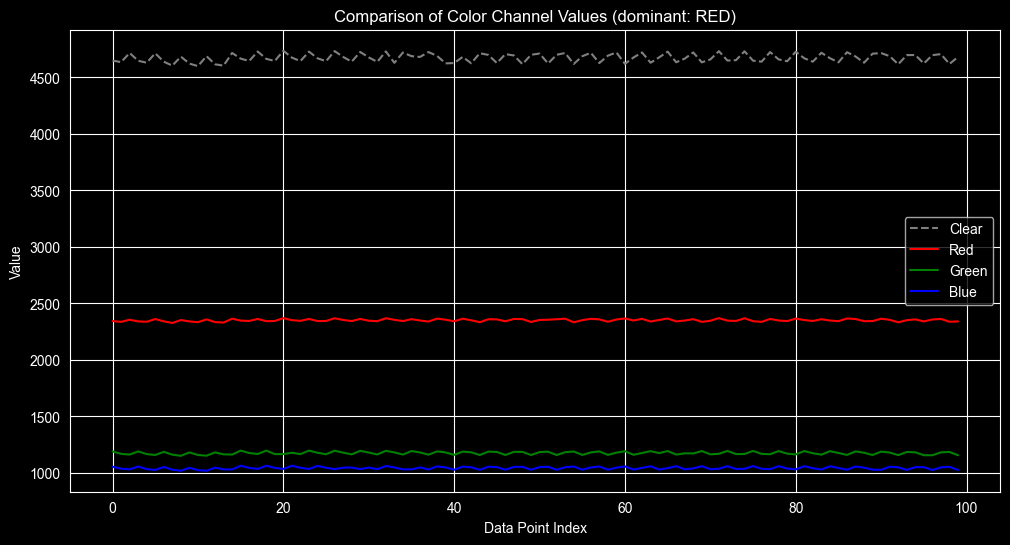

In [49]:
plt.figure(figsize=(12, 6))

# Plotting each list
plt.plot(data['clear'], label='Clear', color='gray', linestyle='--')
plt.plot(data['red'], label='Red', color='red')
plt.plot(data['green'], label='Green', color='green')
plt.plot(data['blue'], label='Blue', color='blue')

plt.title('Comparison of Color Channel Values (dominant: RED)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

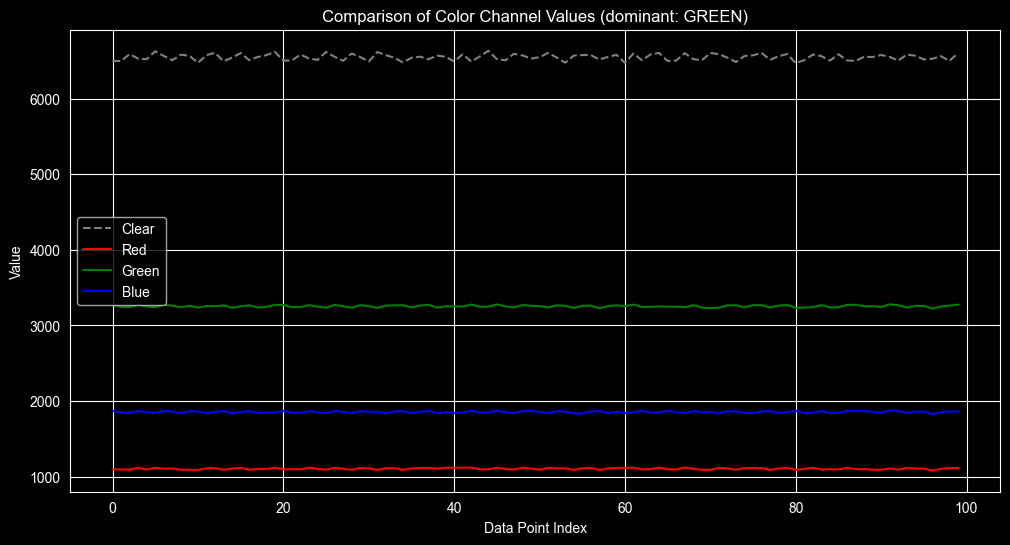

In [59]:
plt.figure(figsize=(12, 6))

# Plotting each list
plt.plot(data['clear'], label='Clear', color='gray', linestyle='--')
plt.plot(data['red'], label='Red', color='red')
plt.plot(data['green'], label='Green', color='green')
plt.plot(data['blue'], label='Blue', color='blue')

plt.title('Comparison of Color Channel Values (dominant: GREEN)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

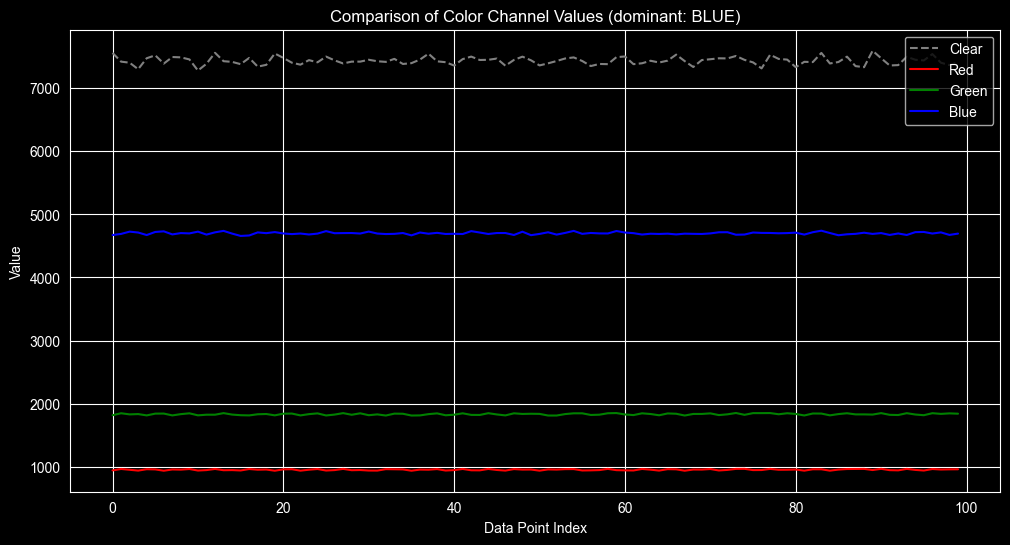

In [61]:
plt.figure(figsize=(12, 6))

# Plotting each list
plt.plot(data['clear'], label='Clear', color='gray', linestyle='--')
plt.plot(data['red'], label='Red', color='red')
plt.plot(data['green'], label='Green', color='green')
plt.plot(data['blue'], label='Blue', color='blue')

plt.title('Comparison of Color Channel Values (dominant: BLUE)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

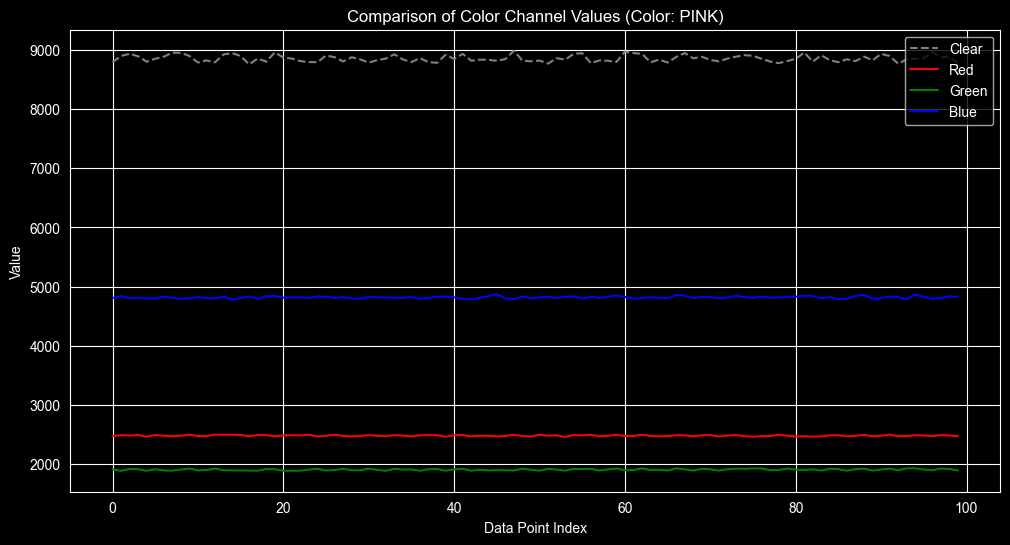

In [64]:
plt.figure(figsize=(12, 6))

# Plotting each list
plt.plot(data['clear'], label='Clear', color='gray', linestyle='--')
plt.plot(data['red'], label='Red', color='red')
plt.plot(data['green'], label='Green', color='green')
plt.plot(data['blue'], label='Blue', color='blue')

plt.title('Comparison of Color Channel Values (Color: PINK)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()